In [14]:
import pandas as pd
import imageio
import glob
import matplotlib
import matplotlib.pyplot as plt
import os
import cv2
from copy import deepcopy
import json
import numpy as np
from skimage.transform import resize
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense,Activation,Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras import backend as K
import keras
import tensorflow as tf

# mask data set

In [13]:
mask_dir_path="/home/jupyter/dataset/mask/train/"
mask_dir=os.listdir(mask_dir_path)

FileNotFoundError: [Errno 2] No such file or directory: '/home/jupyter/dataset/mask/train/'

In [47]:
mask_files = [f for f in glob.glob(mask_dir_path + "**/*color.png", recursive=True)]
print("number of mask file :::",len(mask_files))

number of mask file ::: 2975


In [48]:
mask_files.sort()
mask_files[0]

'/home/jupyter/dataset/mask/train/aachen/aachen_000000_000019_gtFine_color.png'

In [49]:
gray_img=[]
for i in mask_files:
    mask_arr=imageio.imread(i)
    gray_arr=cv2.cvtColor(mask_arr, cv2.COLOR_BGR2GRAY)
    gray_img.append(gray_arr)
    #gray_img.append(resize(gray_arr,(512,512),preserve_range=True))

In [50]:
gray_img=np.array(gray_img)

In [51]:
gray_img.shape

(2975, 1024, 2048)

In [65]:
#np.save('gray_img_outline.npy',gray_img)

In [5]:
train_mask=np.load('train_mask.npy')

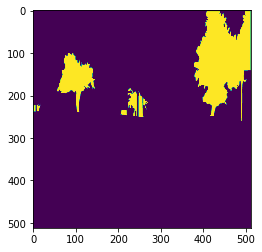

In [8]:
plt.imshow(train_mask[0])

# loading the json file

In [3]:
gray_img=np.load('gray_img_outline.npy')

In [52]:
json_file=[f for f in glob.glob(mask_dir_path + "**/*.json", recursive=True)]
print("number of json file :::",len(json_file))

number of json file ::: 2975


In [53]:
json_file.sort()

In [54]:
import gc
gc.collect()

4

In [55]:
gray_img.shape

(2975, 1024, 2048)

In [56]:
json_array=[]
for i in json_file:
        json_array.append(json.load(open(i)))

In [57]:
new_mask_array=[]
c=0
for j in gray_img:
    for i in json_array[c]["objects"]:
        if(i['label']=='vegetation'):
            temp=cv2.fillPoly(j,[np.asarray(i["polygon"],dtype=np.int32)],255)
        else:
            temp1=cv2.fillPoly(j,[np.asarray(i["polygon"],dtype=np.int32)],0)
    temp[temp!=255]=0
    new_mask_array.append(temp)
    c=c+1

In [58]:
new_mask_array=np.array(new_mask_array)
#new_mask_array=np.reshape(new_mask_array,(new_mask_array.shape[0],new_mask_array.shape[1],new_mask_array.shape[2],1))

In [59]:
mask_final_arr=[]
for image in new_mask_array:
    mask_final_arr.append(resize(image,(512,512),preserve_range=True))

In [60]:
mask_final_arr=np.array(mask_final_arr)

In [61]:
mask_final_arr.shape

(2975, 512, 512)

In [64]:
np.save('train_mask.npy',mask_final_arr)

# checking original mask image

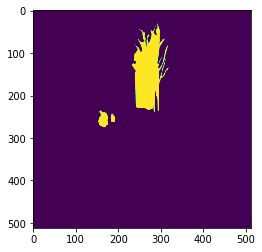

In [14]:
plt.imshow(new_mask_array[9])

# image dataset

In [62]:
image_dir_path="/home/jupyter/dataset/images/train/"

In [63]:
image_dir= os.listdir(image_dir_path)

In [65]:
len(image_dir)

18

In [66]:
images_files = [f for f in glob.glob(image_dir_path + "**/*.png", recursive=True)]
print("number of mask file :::",len(images_files))

number of mask file ::: 2975


In [67]:
images_files.sort()
images_files[0]

'/home/jupyter/dataset/images/train/aachen/aachen_000000_000019_leftImg8bit.png'

In [68]:
image_array=[]
for i in images_files:
        img=imageio.imread(i)
        img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        image_array.append(resize(img,(512,512),preserve_range=True))

In [69]:
image_array=np.array(image_array)

In [71]:
np.save('train_image.npy',image_array)

In [9]:
train_image=np.load('train_image.npy')

In [10]:
train_image.shape

(2975, 512, 512)

# image 

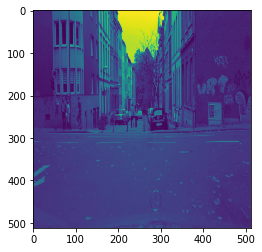

In [70]:
plt.imshow(image_array[9])

# Unet model implemenation 

In [2]:
image_array=np.load('train_image.npy')
new_mask_array=np.load('train_mask.npy')

In [3]:
new_mask_array.shape

(2975, 512, 512)

In [4]:
image_array = image_array.astype('float32')

In [5]:
image_array = image_array - np.mean(image_array)

In [6]:
image_array = image_array / np.std(image_array)

In [7]:
new_mask_array = new_mask_array/255

In [8]:
image_array = image_array[...,np.newaxis]

In [9]:
new_mask_array=new_mask_array[...,np.newaxis]

In [11]:
image_array.shape

(2975, 512, 512, 1)

In [12]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

['/job:localhost/replica:0/task:0/device:GPU:0']

In [13]:
inputs = Input((512, 512, 1))
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
#b1 = BatchNormalization()(conv1)
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
b1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(b1)

conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
#b2 = BatchNormalization()(conv2)
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
b2 = BatchNormalization()(conv2)
drop2 = Dropout(0.5)(b2)
pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)

conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
#b3 = BatchNormalization()(conv3)
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
b3 = BatchNormalization()(conv3)
drop3 = Dropout(0.25)(b3)
pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)

conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
#b4= BatchNormalization()(conv4)
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
b4 = BatchNormalization()(conv4)
drop4 = Dropout(0.5)(b4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
#b5 = BatchNormalization()(conv5)
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)
b5 = BatchNormalization()(conv5)
drop5 = Dropout(0.5)(b5)

up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(drop5), drop4], axis=3)
#b6 = BatchNormalization(momentum=0.5)(up6)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
#b6 = BatchNormalization()(conv6)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
b6 = BatchNormalization()(conv6)
drop6 = Dropout(0.5)(b6)

up7 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(drop6), drop3], axis=3)
#b7 = BatchNormalization(momentum=0.5)(up7)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
#b7 = BatchNormalization()(conv7)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
b7 = BatchNormalization()(conv7)
drop7 = Dropout(0.5)(b7)

up8 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(drop7), drop2], axis=3)
#b8 = BatchNormalization(momentum=0.5)(up8)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
#b8 = BatchNormalization()(conv8)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
b8 = BatchNormalization()(conv8)
drop8 = Dropout(0.5)(b8)

up9 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(drop8), conv1], axis=3)
#b9 = BatchNormalization(momentum=0.5)(up9)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
#b9 = BatchNormalization()(conv9)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
b9 = BatchNormalization()(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(b9)

model = Model(inputs=[inputs], outputs=[conv10])

model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])


NameError: name 'Input' is not defined

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 64) 256         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [43]:
model.fit(image_array, new_mask_array, batch_size=1, epochs=10, verbose=1, shuffle=True)

Epoch 1/10
2975/2975 [==============================] - 3318s 1s/sample - loss: 0.2727 - acc: 0.9038
Epoch 2/10
2975/2975 [==============================] - 3316s 1s/sample - loss: 0.1546 - acc: 0.9339
Epoch 3/10
2975/2975 [==============================] - 3316s 1s/sample - loss: 0.1333 - acc: 0.9410
Epoch 4/10
2975/2975 [==============================] - 3312s 1s/sample - loss: 0.1215 - acc: 0.9451
Epoch 5/10
2975/2975 [==============================] - 3309s 1s/sample - loss: 0.1146 - acc: 0.9474
Epoch 6/10
2975/2975 [==============================] - 3310s 1s/sample - loss: 0.1080 - acc: 0.9494
Epoch 7/10
2975/2975 [==============================] - 3315s 1s/sample - loss: 0.1027 - acc: 0.9511
Epoch 8/10
2975/2975 [==============================] - 3311s 1s/sample - loss: 0.0975 - acc: 0.9528
Epoch 9/10
2975/2975 [==============================] - 3310s 1s/sample - loss: 0.0942 - acc: 0.9537
Epoch 10/10
2975/2975 [==============================] - 3310s 1s/sample - loss: 0.0913 - a

In [36]:
model.save('unet_model.h5')

# testing and prediction of model

In [17]:
import tensorflow
from tensorflow.keras.models import load_model
model=load_model('model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [19]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 512, 512, 64) 640         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 512, 512, 64) 36928       conv2d_19[0][0]                  
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 512, 512, 64) 256         conv2d_20[0][0]                  
____________________________________________________________________________________________

In [21]:
model.fit(image_array, new_mask_array, batch_size=1, epochs=5, verbose=1, shuffle=True)

Epoch 1/5
2975/2975 [==============================] - 1460s 491ms/sample - loss: 0.0669 - acc: 0.9573
Epoch 2/5
 669/2975 [=====>........................] - ETA: 19:01 - loss: 0.0662 - acc: 0.9578

KeyboardInterrupt: 

In [20]:
testing_image_arr=np.load('test_image.npy')

In [22]:
testing_image_arr[0]

array([[128.  , 123.  , 119.5 , ..., 154.  , 170.25, 116.75],
       [138.75, 132.5 , 124.5 , ..., 152.5 , 166.75, 116.  ],
       [ 90.75,  98.25, 106.5 , ..., 150.  , 163.  , 114.75],
       ...,
       [ 99.  ,  98.  ,  99.5 , ...,  32.5 ,  86.  ,  97.75],
       [ 99.  ,  98.  ,  99.75, ...,  29.5 ,  51.  ,  91.5 ],
       [ 99.  ,  98.  , 100.  , ...,  30.25,  32.25,  47.25]])

In [23]:
testing_image_arr = testing_image_arr.astype('float32')

In [24]:
testing_image_arr = testing_image_arr - np.mean(testing_image_arr)

In [25]:
testing_image_arr = testing_image_arr / np.std(testing_image_arr)

In [26]:
testing_image_arr = testing_image_arr[...,np.newaxis]

In [27]:
testing_image_arr.shape

(500, 512, 512, 1)

In [28]:
mask_pred=[]
for image in testing_image_arr:
    image=image[np.newaxis,...]
    predicted = model.predict(image, verbose=1)
    mask_pred.append(predicted)

1/1 [==============================] - 0s 175ms/sample


In [29]:
mask_pred=np.array(mask_pred)

In [30]:
mask_pred[0]

array([[[[0.00505072],
         [0.00307527],
         [0.00326651],
         ...,
         [0.002969  ],
         [0.00409433],
         [0.00453833]],

        [[0.00136477],
         [0.00144318],
         [0.00150025],
         ...,
         [0.00171745],
         [0.00200453],
         [0.00190383]],

        [[0.00210747],
         [0.00233793],
         [0.00253317],
         ...,
         [0.00242648],
         [0.00237051],
         [0.00241786]],

        ...,

        [[0.0023492 ],
         [0.00186354],
         [0.00141314],
         ...,
         [0.00666636],
         [0.00503829],
         [0.00326705]],

        [[0.00252691],
         [0.0018723 ],
         [0.00143653],
         ...,
         [0.00433785],
         [0.00458503],
         [0.00330603]],

        [[0.00465256],
         [0.00246552],
         [0.00279844],
         ...,
         [0.00450251],
         [0.00715336],
         [0.00439385]]]], dtype=float32)

In [33]:
mask_pred=np.squeeze(mask_pred, axis=1)

In [34]:
mask_pred.shape

(500, 512, 512, 1)

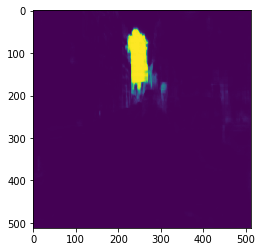

In [35]:
plt.imshow(np.squeeze(mask_pred[0], axis=2))

In [56]:
# Saving numpy array of the prediction made by model
np.save('predicted_mask.npy', mask_pred)

In [4]:
# loading predicted mask of test image
mask_pred=np.load('predicted_mask.npy')

In [36]:
# loading test ground truth mask image
mask_real = np.load('test_real_mask.npy')

In [38]:
#adding channel in the np array
mask_real=mask_real[...,np.newaxis]
#mask_pred = mask_pred[...,np.newaxis]

In [7]:
# squeezing array
mask_pred=np.squeeze(mask_pred,axis=3)

In [39]:
mask_real.shape

(500, 512, 512, 1)

# Calculating matrix for iou

In [41]:
from copy import deepcopy

In [40]:
mask_real = mask_real.astype('float32')

In [42]:
mask_pred.shape

(500, 512, 512, 1)

In [43]:
mask_real.shape

(500, 512, 512, 1)

In [44]:
temp_mask=deepcopy(mask_pred)

In [45]:
# threshold for predicted mask.
for image in temp_mask:
    image[image<0.5]=0
    image[image>=0.5]=1

In [46]:
# threshold for original mask.
for image in mask_real:
    image[image<0.5]=0
    image[image>=0.5]=1

In [61]:
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

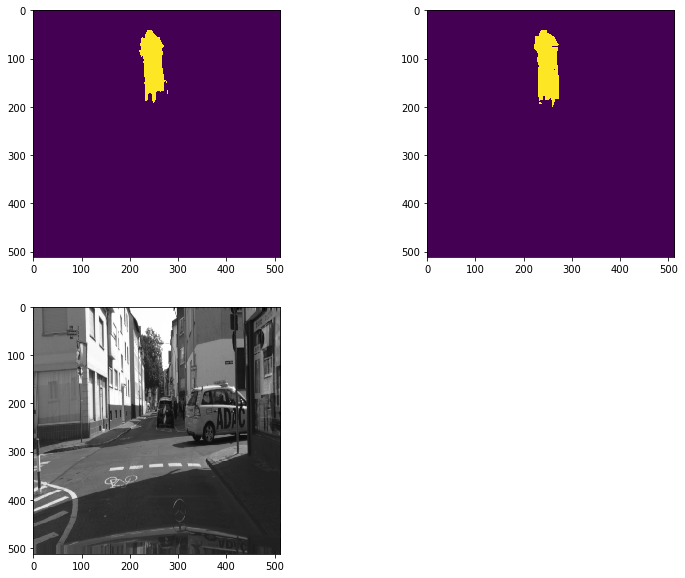

In [60]:
plt.subplot(2, 3, 1)
plt.imshow(np.squeeze(temp_mask[0],axis=2))

plt.subplot(2, 3, 2)
plt.imshow(np.squeeze(mask_real[0],axis=2))

plt.subplot(2, 3, 4)
plt.imshow(np.squeeze(test_image[0],axis=2),cmap='gray')

plt.show()

# calculating iou

In [50]:
arr_iou=[]
for i in range(len(mask_real)):
    intersection = np.logical_and(mask_real[i],temp_mask[i])
    union = np.logical_or(mask_real[i], temp_mask[i])
    iou_score = np.sum(intersection) / np.sum(union)
    arr_iou.append(iou_score)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


In [52]:
arr_iou=np.array(arr_iou)

In [53]:
arr_iou= np.nan_to_num(arr_iou, copy=True, nan=1.0)

In [54]:
mean_iou=arr_iou.mean()

In [55]:
mean_iou

0.7404357178014193